In [1]:
# Set the matplotlib backend and make the plots a bit bigger
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]

from xrdfit.spectrum_fitting import PeakParams, FitSpectrum
import re
import sys
import pandas as pd
#import pyFAI.gui.jupyter
import pyFAI
import numpy as np
import imageio
import matplotlib.pyplot as plt
#import fabio
#from pyFAI.calibrant import CALIBRANT_FACTORY
#from pyFAI.goniometer import SingleGeometry

sys.path.append("../../src/diamond_analysis")
from load_data import list_runs, load_tiff

In [2]:
# define the data directory
dir_data = "../../.data_LW03"

# the logbook file
logbook = "../../.data_LW03/logbook_LW03_subset.ods"

# the calibration .poni files created by Dioptas
poni_file_q0 = "../../.data_LW03/poni/Quad0.poni"
poni_file_q1 = "../../.data_LW03/poni/Quad1.poni"
poni_file_q2 = "../../.data_LW03/poni/Quad2.poni"
poni_file_q3 = "../../.data_LW03/poni/Quad3.poni"


# the mask files for the quad detectors
mask_q0 = "../../.data_LW03/mask/Quad0.mask"
mask_q1 = "../../.data_LW03/mask/Quad1.mask"
mask_q2 = "../../.data_LW03/mask/Quad2.mask"
mask_q3 = "../../.data_LW03/mask/Quad3.mask"

# define the pattern for a background file
pattern_runs = re.compile("r[0-9]*_bkgCorrected")

# define the azimuthal intyegrator objects from pyFAI
q0_ai = pyFAI.load(poni_file_q0)
q1_ai = pyFAI.load(poni_file_q1)
q2_ai = pyFAI.load(poni_file_q2)
q3_ai = pyFAI.load(poni_file_q3)

# load the masks as np arrays

q0_mask = np.array(imageio.imread(mask_q0),dtype=int)
q1_mask = np.array(imageio.imread(mask_q1),dtype=int)
q2_mask = np.array(imageio.imread(mask_q2),dtype=int)
q3_mask = np.array(imageio.imread(mask_q3),dtype=int)
q3_mask = imageio.imread(mask_q3)


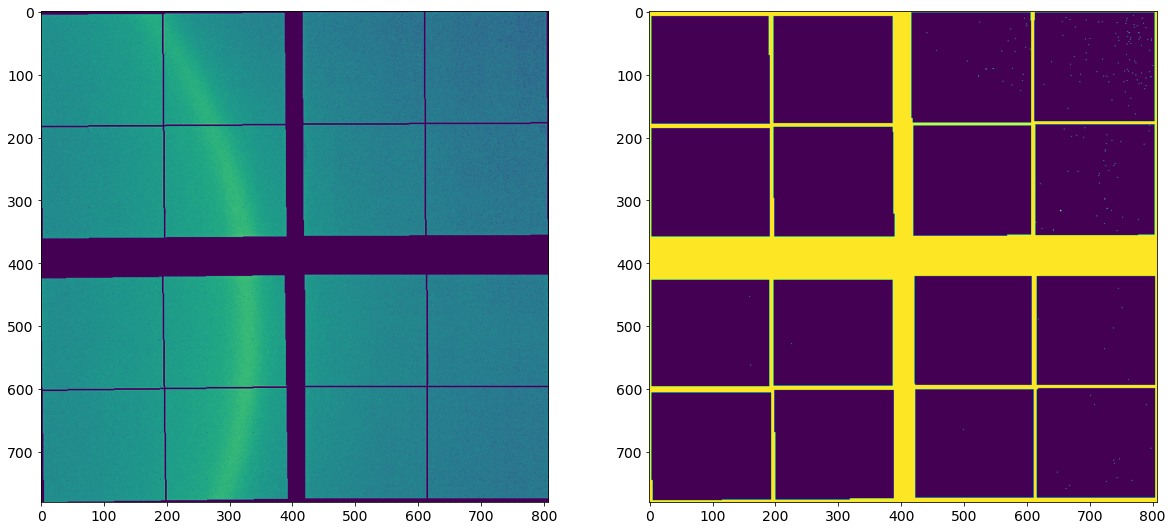

In [3]:
#display(list(logbook_df.columns.values))

r182_q3 = load_tiff(182,3,dir_data)
fig, ax = plt.subplots(1,2,figsize=(20,19))
ax[0].imshow((np.abs(r182_q3))**(1/4))
neg = ax[1].imshow(q3_mask)

In [4]:
result2d = q3_ai.integrate2d(r182_q3,
                        npt_rad=1000,
                        npt_azim=1000,
                        correctSolidAngle=True,
                        mask=q3_mask)

result1d = q3_ai.integrate1d(r182_q3,
                        npt=1000,
                        correctSolidAngle=True,
                        mask=q3_mask)

In [5]:
# flip the intensity data to order cakes clockwise rather than anticlockwise
intensity = np.flip(result2d.intensity.T, axis=1)
    
# reshape radial labels to 2D array so they can be attached to the intensity data.
radial = np.reshape(result2d.radial, (-1, 1))
    
result_array = np.hstack((radial, intensity))

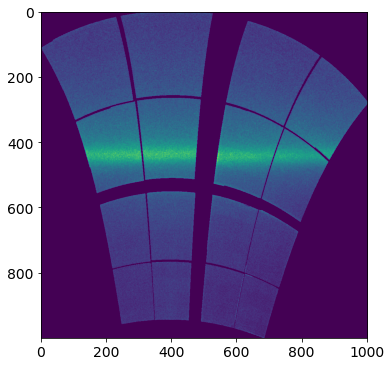

In [6]:
plt.imshow(result_array)

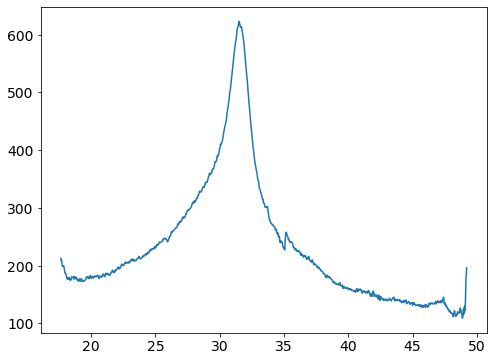

In [7]:
plt.plot(result1d[0],result1d[1])